This notebook shows an example of how to retrain 21cmVAE and the AuteoEncoder-based Emulator (from Appendix A).

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import VeryAccurateEmulator as VAE

## Training 21cmVAE

In [2]:
emulator = VAE.emulator.DirectEmulator()
emulator.emulator.summary()

Model: "emulator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               2304      
                                                                 
 dense_1 (Dense)             (None, 352)               101728    
                                                                 
 dense_2 (Dense)             (None, 288)               101664    
                                                                 
 dense_3 (Dense)             (None, 224)               64736     
                                                                 
 dense_4 (Dense)             (None, 451)               101475    
                                                                 
Total params: 371,907
Trainable params: 371,907
Non-trainable params: 0
_________________________________________________________________


2022-03-19 16:59:31.585940: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-19 16:59:31.586040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thinkpad-ubuntu): /proc/driver/nvidia/version does not exist
2022-03-19 16:59:31.587571: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
loss_fcn = VAE.emulator.relative_mse_loss(emulator.signal_train)  # loss function for training
learning_rate = 0.01
opt = tf.keras.optimizers.Adam(learning_rate)

emulator.emulator.compile(optimizer=opt, loss=loss_fcn)

In [4]:
# define callbacks (optional)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, min_delta=1e-10, restore_best_weights=True, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=5, factor=0.95, verbose=1, min_delta=5e-9, min_lr=1e-4
)

cb = [early_stopping, reduce_lr]

# train
train_loss, val_loss = emulator.train(epochs=350, callbacks=cb)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 46: ReduceLROnPlateau reducing learning rate to 0.009499999787658453.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.009024999709799886.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.008573750033974648.

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.008145062532275914.

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0077378091402351854.

Epoch 79: ReduceLROnPlateau reducing learning rate to 0.007350918860174715.

Epoch 84: ReduceLROnPlateau reducing learning rate to 0.006983372895047068.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.006634204206056892.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.006302493973635137.

Epoch 100: ReduceLROnPlateau reducing learning rate to 0.005987369385547936.

Epoch 105: ReduceLROnPlateau reducing learning rate to 0.005688000982627272.

Epoch 110: ReduceLROnPlateau reducing learning rate to 0.005403600889258086.

Epoch 115: ReduceLROnPlateau reducing learning rate to 0.00513342104386

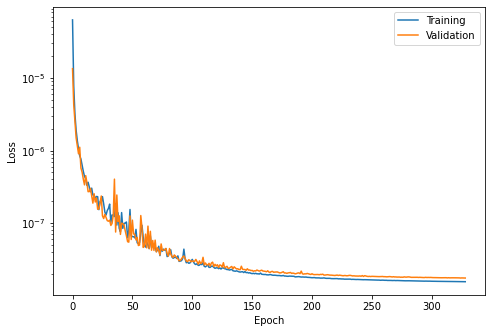

In [5]:
fig = plt.figure()
ax = fig.add_axes([0., 0., 1., 1.])
ax.plot(train_loss, label='Training')
ax.plot(val_loss, label='Validation')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
plt.show()

In [6]:
rmse = emulator.test_error()
print(rmse.mean())

0.3466905


## Training the Autoencoder-based Emulator

In [7]:
ae_em = VAE.emulator.AutoEncoderEmulator()
ae_em.emulator.summary()
ae_em.autoencoder.summary()
ae_em.autoencoder.encoder.summary()
ae_em.autoencoder.decoder.summary()

Model: "ae_emualtor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 352)               2816      
                                                                 
 dense_11 (Dense)            (None, 352)               124256    
                                                                 
 dense_12 (Dense)            (None, 352)               124256    
                                                                 
 dense_13 (Dense)            (None, 224)               79072     
                                                                 
 dense_14 (Dense)            (None, 9)                 2025      
                                                                 
Total params: 332,425
Trainable params: 332,425
Non-trainable params: 0
_________________________________________________________________
Model: "auto_encoder"
___________________________

In [8]:
learning_rate = 0.01
opt = tf.keras.optimizers.Adam(learning_rate)

ae_loss_fcn = VAE.emulator.relative_mse_loss(ae_em.signal_train)  # loss function for training
em_loss_fcn = tf.keras.metrics.mean_squared_error

ae_em.autoencoder.compile(optimizer=opt, loss=ae_loss_fcn)
ae_em.emulator.compile(optimizer=opt, loss=em_loss_fcn)

In [9]:
# define callbacks (optional)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, min_delta=5e-10, restore_best_weights=True, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=5, factor=0.9, verbose=1, min_delta=5e-9, min_lr=1e-4
)
ae_cb = [early_stopping, reduce_lr]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, min_delta=5e-5, restore_best_weights=True, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=5, factor=0.9, verbose=1, min_delta=5e-3, min_lr=1e-4
)
em_cb = [early_stopping, reduce_lr]

# train
ae_loss, ae_val_loss, em_loss, em_val_loss = ae_em.train(epochs=350, ae_callbacks=ae_cb, em_callbacks=em_cb)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 33: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.

Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0038742044940590858.

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.003486784128472209.

Epoch 93: ReduceLROnPlateau reducing learning rate to 0.003138105757534504.

Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0028242952656000854.

Epoch 103: ReduceLROnPlateau reducing learning rate to 0.0025418657809495

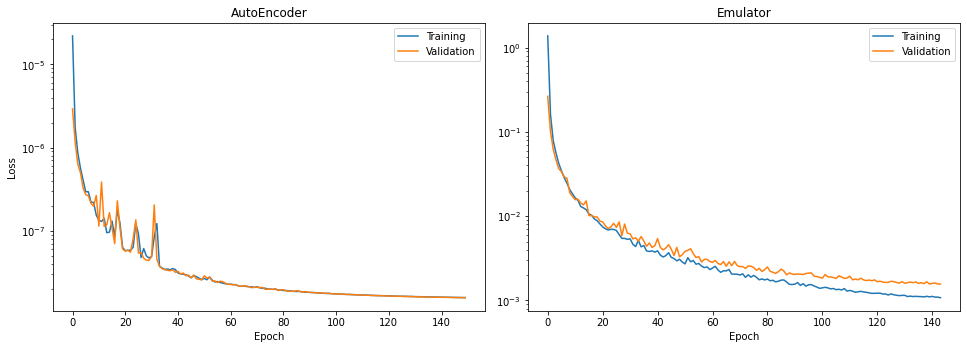

In [10]:
fig = plt.figure()
ax1 = fig.add_axes([0., 0., 1., 1.])
ax1.plot(ae_loss, label='Training')
ax1.plot(ae_val_loss, label='Validation')
ax1.legend()
ax1.set_title('AutoEncoder')
ax1.set_ylabel('Loss')
ax2 = fig.add_axes([1.1, 0., 1., 1.])
ax2.plot(em_loss, label='Training')
ax2.plot(em_val_loss, label='Validation')
ax2.legend()
ax2.set_title('Emulator')
plt.setp([ax1, ax2], xlabel='Epoch', yscale='log')
plt.show()

In [11]:
rmse = ae_em.test_error()
print(rmse.mean())

0.45319167
